In [1]:
#Attribution: Used Gemini-3-pro LLM to help brainstorm appropriate EDA metrics, and visualizaions. Additionally helping with linting and syntax for each sections.

# Vancouver Crime Analysis -- EDA for VanCrimeWatch

**Research Question:** How would new business owners choose between various localities in Vancouver depending on the crime rate and types of crime?

**Data scope:** 2023 -- 2026 (2020--2022 excluded as censored).  
**Source:** Vancouver Police Department open data -- crime incidents by neighbourhood.

---
## 1. Setup and Data Loading

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 120
})

In [27]:
# Load CSVs for 2023-2026
data_dir = os.path.join('..', 'data', 'raw')
years = [2023, 2024, 2025, 2026]

dfs = []
for year in years:
    path = os.path.join(data_dir, f'crimedata_csv_AllNeighbourhoods_{year}.csv')
    df_year = pd.read_csv(path)
    dfs.append(df_year)

df = pd.concat(dfs, ignore_index=True)
print(f'Combined dataset: {df.shape[0]:,} rows, {df.shape[1]} columns')
df.head()

Combined dataset: 106,014 rows, 10 columns


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2023,3,20,23,56,10XX PACIFIC ST,West End,490284.2663,5.458343e+06
1,Break and Enter Commercial,2023,12,4,0,48,10XX PACIFIC ST,West End,490284.2663,5.458343e+06
2,Break and Enter Commercial,2023,4,15,6,24,10XX PACIFIC ST,West End,490285.0160,5.458342e+06
3,Break and Enter Commercial,2023,5,5,4,15,10XX PACIFIC ST,West End,490285.0160,5.458342e+06
4,Break and Enter Commercial,2023,1,12,2,28,10XX PACIFIC ST,West End,490352.2816,5.458276e+06


---
## 2. Data Cleaning

In [28]:
# Check for missing / empty neighbourhoods
print('Missing NEIGHBOURHOOD values:', df['NEIGHBOURHOOD'].isna().sum())
print('Empty-string NEIGHBOURHOOD values:', (df['NEIGHBOURHOOD'] == '').sum())

# Drop rows with missing or empty neighbourhood
df = df[df['NEIGHBOURHOOD'].notna() & (df['NEIGHBOURHOOD'] != '')].copy()
print(f'After cleaning: {df.shape[0]:,} rows')

Missing NEIGHBOURHOOD values: 24
Empty-string NEIGHBOURHOOD values: 0
After cleaning: 105,990 rows


In [29]:
# Confirm data scope
print('Years present:', sorted(df['YEAR'].unique()))
print('\nCrime types:')
for ct in sorted(df['TYPE'].unique()):
    print(f'  - {ct}')
print(f'\nNeighbourhoods: {df["NEIGHBOURHOOD"].nunique()}')

Years present: [np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026)]

Crime types:
  - Break and Enter Commercial
  - Break and Enter Residential/Other
  - Homicide
  - Mischief
  - Offence Against a Person
  - Other Theft
  - Theft from Vehicle
  - Theft of Bicycle
  - Theft of Vehicle
  - Vehicle Collision or Pedestrian Struck (with Fatality)
  - Vehicle Collision or Pedestrian Struck (with Injury)

Neighbourhoods: 24


In [30]:
# Create a proper date column for temporal analysis
df['DATE'] = pd.to_datetime(
    df[['YEAR', 'MONTH', 'DAY']].rename(
        columns={'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'}
    ),
    errors='coerce'
)
print('Date range:', df['DATE'].min(), 'to', df['DATE'].max())

Date range: 2023-01-01 00:00:00 to 2026-02-06 00:00:00


---
## 3. Business-Relevant Crime Subset

For a prospective business owner, the most relevant crime types are those that directly affect commercial properties and operations:

- **Break and Enter Commercial** -- direct threat to a storefront or office.
- **Theft from Vehicle** -- affects employees, customers, and delivery vehicles.
- **Other Theft** -- shoplifting and general property theft.
- **Mischief** -- vandalism and property damage.
- **Theft of Vehicle** -- risk to business and employee vehicles.

In [31]:
business_crime_types = [
    'Break and Enter Commercial',
    'Theft from Vehicle',
    'Other Theft',
    'Mischief',
    'Theft of Vehicle'
]

biz = df[df['TYPE'].isin(business_crime_types)].copy()
print(f'Business-relevant subset: {biz.shape[0]:,} rows '
      f'({biz.shape[0]/df.shape[0]*100:.1f}% of total)')

Business-relevant subset: 85,240 rows (80.4% of total)


---
## 4. Summary Statistics

In [32]:
# Total business-relevant crimes by neighbourhood (2023-2025 full years only hence 2026 excluded)
biz_full = biz[biz['YEAR'].isin([2023, 2024, 2025])]

neighbourhood_totals = (
    biz_full.groupby('NEIGHBOURHOOD')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='TOTAL_INCIDENTS')
)
neighbourhood_totals

,NEIGHBOURHOOD,TOTAL_INCIDENTS
0,Central Business District,29163
1,West End,6361
2,Renfrew-Collingwood,6275
3,Strathcona,5279
4,Mount Pleasant,5169
5,Fairview,4003
6,Kensington-Cedar Cottage,3623
7,Grandview-Woodland,3488
8,Sunset,3301
9,Kitsilano,2928


In [33]:
# Breakdown by neighbourhood and crime type
crime_by_neighbourhood = (
    biz_full.groupby(['NEIGHBOURHOOD', 'TYPE'])
    .size()
    .unstack(fill_value=0)
)

# Sort by total descending
crime_by_neighbourhood['_total'] = crime_by_neighbourhood.sum(axis=1)
crime_by_neighbourhood = crime_by_neighbourhood.sort_values('_total', ascending=False)
crime_by_neighbourhood = crime_by_neighbourhood.drop(columns='_total')
crime_by_neighbourhood

TYPE,Break and Enter Commercial,Mischief,Other Theft,Theft from Vehicle,Theft of Vehicle
NEIGHBOURHOOD,,,,,
Central Business District,1218,6890,14182,6616,257
West End,425,1047,3272,1520,97
Renfrew-Collingwood,220,631,4497,773,154
Strathcona,307,1611,2063,1136,162
Mount Pleasant,383,1012,2814,857,103
Fairview,349,732,2077,778,67
Kensington-Cedar Cottage,192,746,1510,1036,139
Grandview-Woodland,256,930,1334,770,198
Sunset,98,385,2156,546,116


In [34]:
# Year-over-year totals by neighbourhood
yearly_trends = (
    biz_full.groupby(['YEAR', 'NEIGHBOURHOOD'])
    .size()
    .unstack(fill_value=0)
)
yearly_trends

NEIGHBOURHOOD,Arbutus Ridge,Central Business District,Dunbar-Southlands,Fairview,Grandview-Woodland,Hastings-Sunrise,Kensington-Cedar Cottage,Kerrisdale,Killarney,Kitsilano,...,Renfrew-Collingwood,Riley Park,Shaughnessy,South Cambie,Stanley Park,Strathcona,Sunset,Victoria-Fraserview,West End,West Point Grey
YEAR,,,,,,,,,,,,,,,,,,,,,
2023,206,10234,266,1445,1243,717,1284,290,447,955,...,2289,504,136,269,118,2025,1233,439,2156,202
2024,226,9930,218,1277,1062,650,1061,254,373,1049,...,1986,412,186,255,118,1595,1078,464,2096,198
2025,173,8999,196,1281,1183,766,1278,290,363,924,...,2000,470,121,268,125,1659,990,388,2109,172


---
## 5. Visualizations

### 5.1 Stacked Bar Chart -- Business-Relevant Crimes by Neighbourhood (2023-2025)

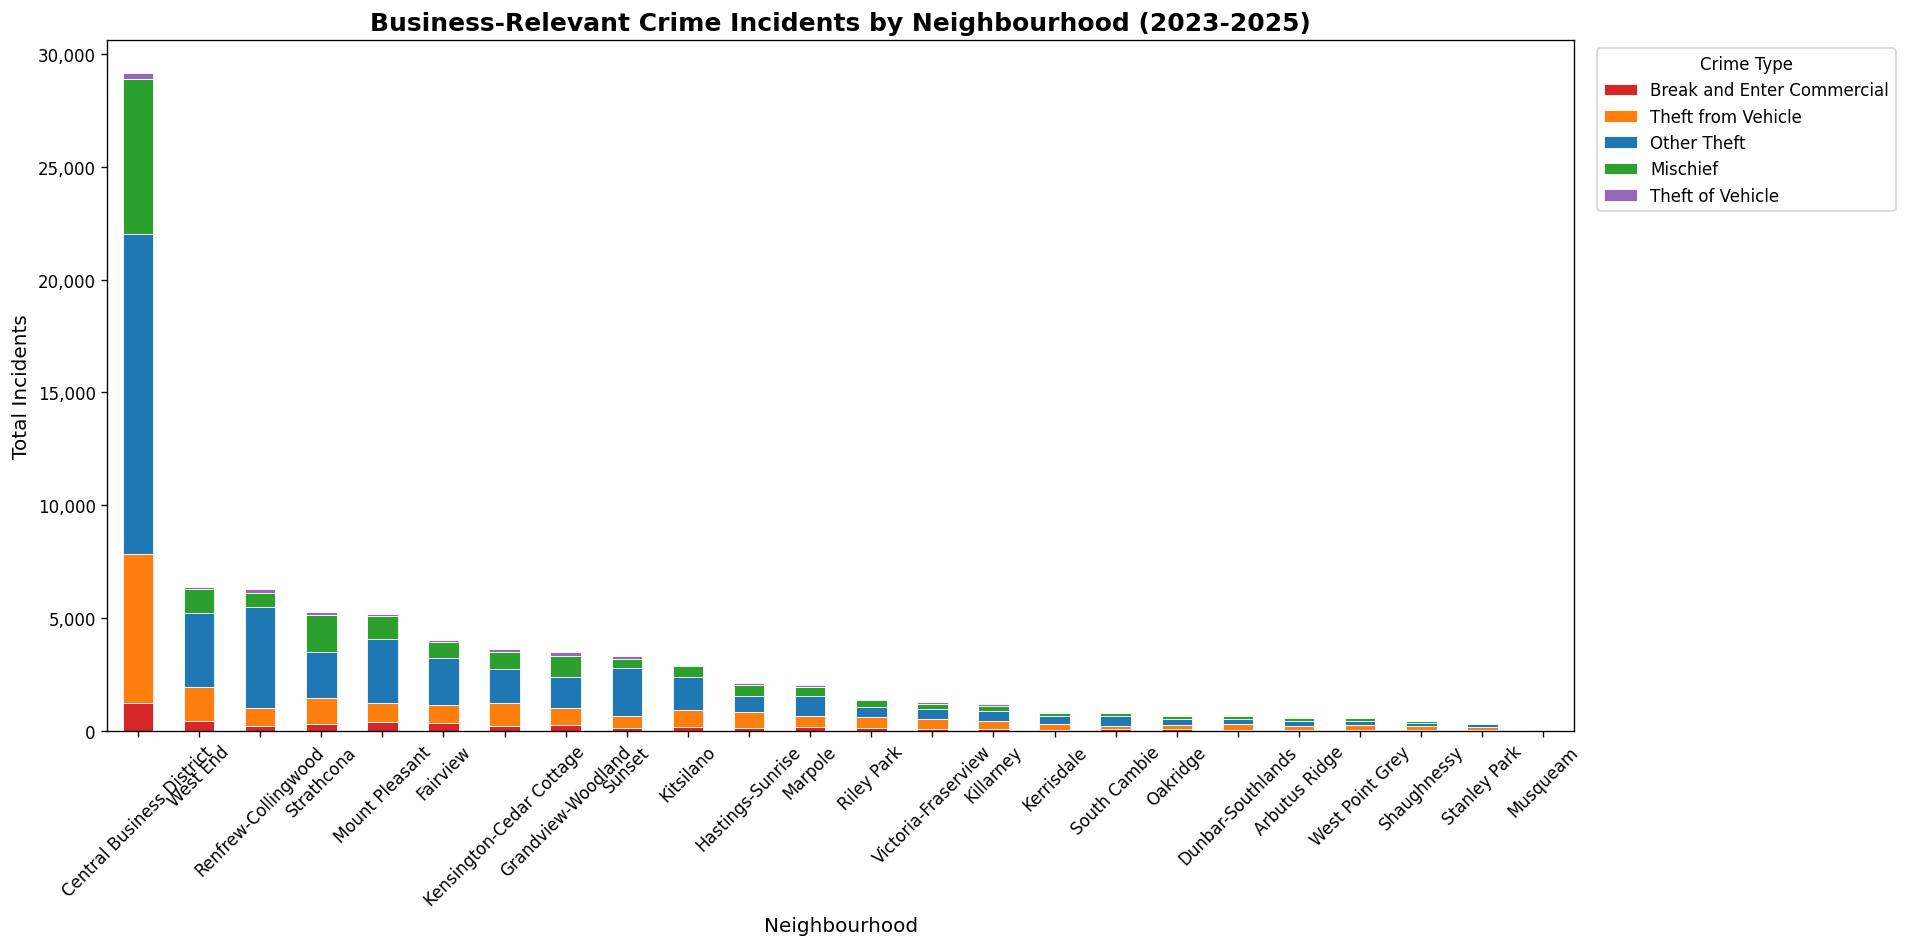

In [35]:
# Colour palette for crime types
colours = {
    'Break and Enter Commercial': '#d62728',
    'Theft from Vehicle':        '#ff7f0e',
    'Other Theft':               '#1f77b4',
    'Mischief':                  '#2ca02c',
    'Theft of Vehicle':          '#9467bd'
}

fig, ax = plt.subplots(figsize=(16, 8))

# Reorder columns for consistent legend
plot_order = [
    'Break and Enter Commercial',
    'Theft from Vehicle',
    'Other Theft',
    'Mischief',
    'Theft of Vehicle'
]
plot_data = crime_by_neighbourhood[plot_order]

plot_data.plot(
    kind='bar',
    stacked=True,
    color=[colours[c] for c in plot_order],
    ax=ax,
    edgecolor='white',
    linewidth=0.5
)

ax.set_title('Business-Relevant Crime Incidents by Neighbourhood (2023-2025)', fontsize=15, fontweight='bold')
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Total Incidents')
ax.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig('../img/biz_crime_by_neighbourhood.png', bbox_inches='tight')
plt.show()

### 5.2 Year-over-Year Crime Trend -- Top 5 and Bottom 5 Neighbourhoods

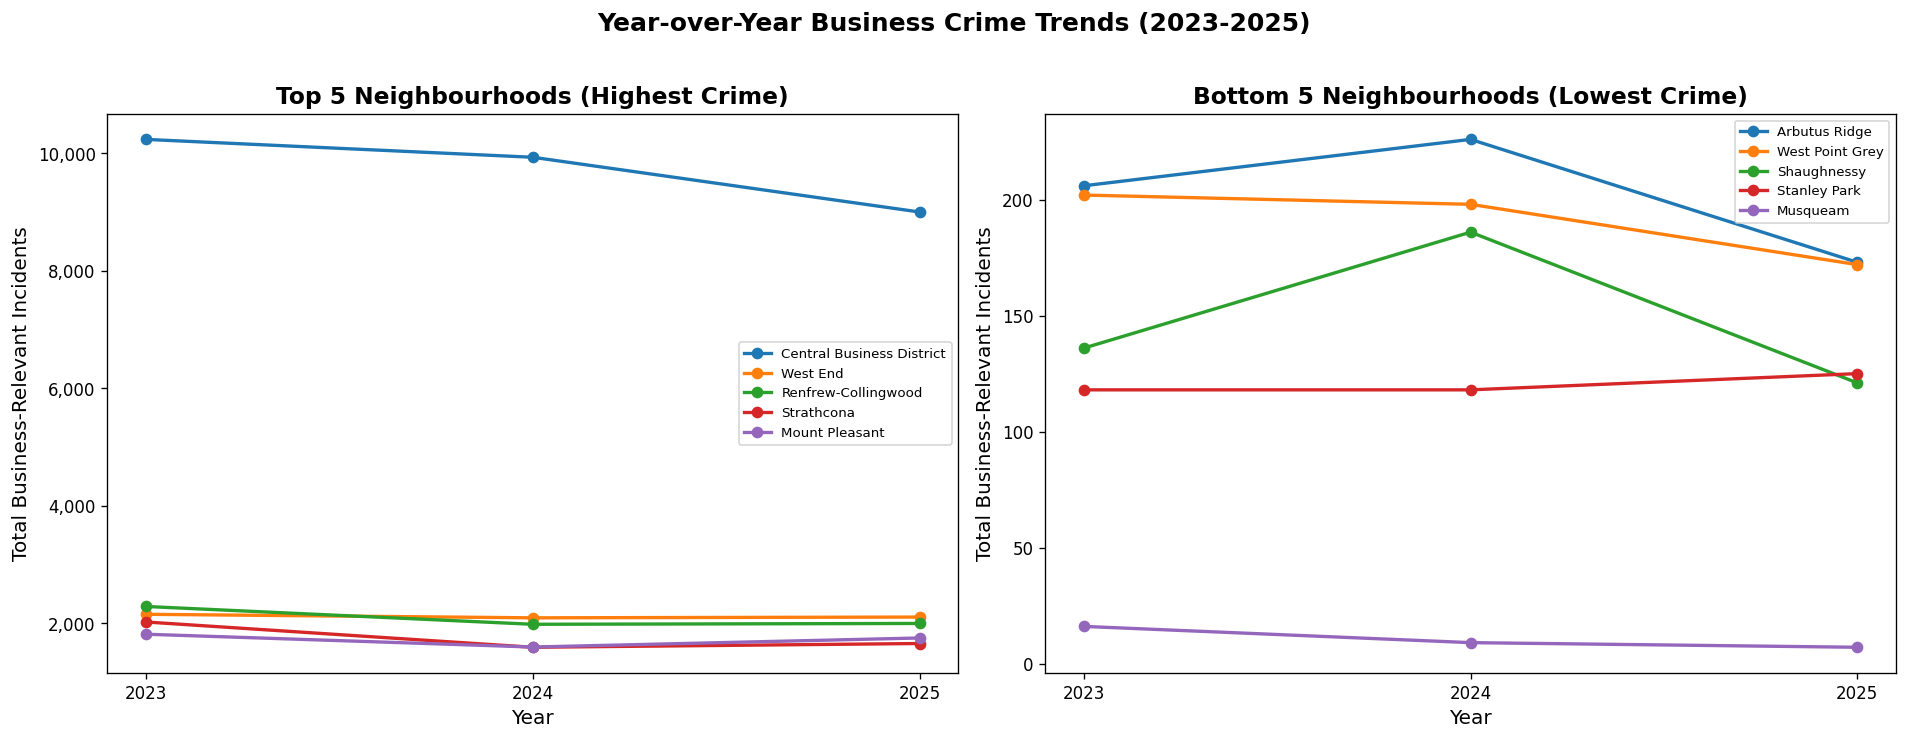

In [36]:
# Identify top-5 and bottom-5 neighbourhoods by total incidents
totals_sorted = neighbourhood_totals.sort_values('TOTAL_INCIDENTS', ascending=False)
top5 = totals_sorted.head(5)['NEIGHBOURHOOD'].tolist()
bottom5 = totals_sorted.tail(5)['NEIGHBOURHOOD'].tolist()

selected = top5 + bottom5

trend_data = (
    biz_full[biz_full['NEIGHBOURHOOD'].isin(selected)]
    .groupby(['YEAR', 'NEIGHBOURHOOD'])
    .size()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Top 5 (highest crime)
for neighbourhood in top5:
    if neighbourhood in trend_data.columns:
        axes[0].plot(
            trend_data.index, trend_data[neighbourhood],
            marker='o', linewidth=2, label=neighbourhood
        )
axes[0].set_title('Top 5 Neighbourhoods (Highest Crime)', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Business-Relevant Incidents')
axes[0].legend(fontsize=8)
axes[0].set_xticks([2023, 2024, 2025])
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Bottom 5 (lowest crime)
for neighbourhood in bottom5:
    if neighbourhood in trend_data.columns:
        axes[1].plot(
            trend_data.index, trend_data[neighbourhood],
            marker='o', linewidth=2, label=neighbourhood
        )
axes[1].set_title('Bottom 5 Neighbourhoods (Lowest Crime)', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Business-Relevant Incidents')
axes[1].legend(fontsize=8)
axes[1].set_xticks([2023, 2024, 2025])
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.suptitle('Year-over-Year Business Crime Trends (2023-2025)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../img/biz_crime_yoy_trend.png', bbox_inches='tight')
plt.show()

### 5.3 Heatmap -- Crime Type Distribution Across Neighbourhoods

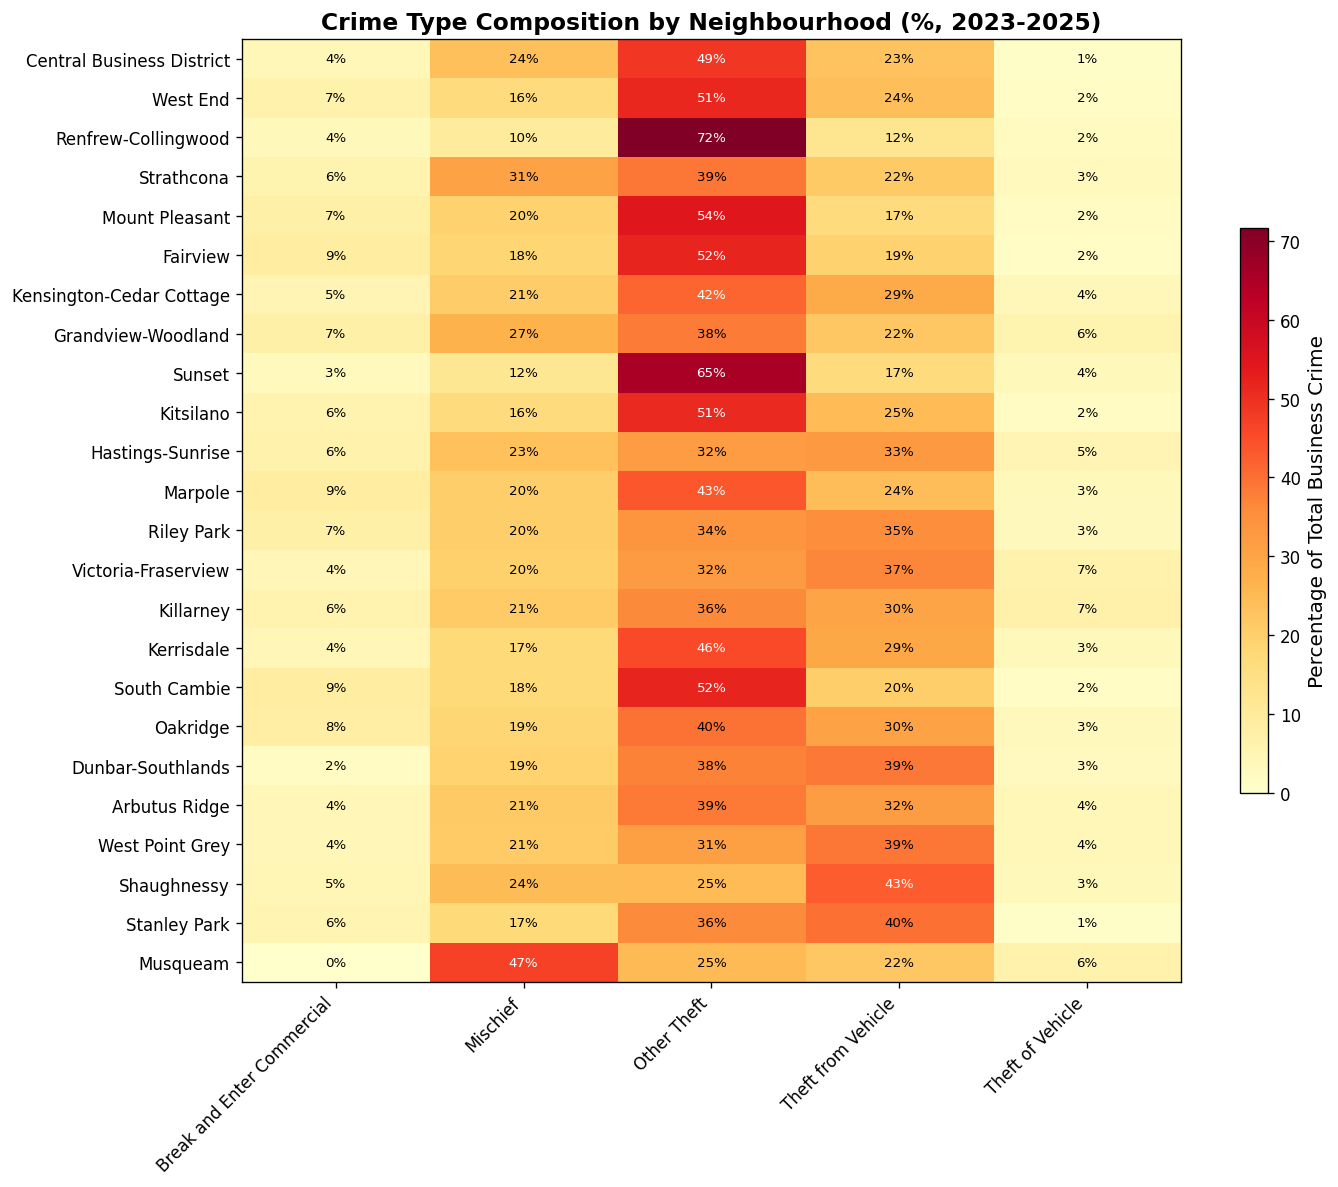

In [37]:
# Normalise each neighbourhood's crime to percentages for composition comparison
crime_pct = crime_by_neighbourhood.div(crime_by_neighbourhood.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(crime_pct.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(crime_pct.columns)))
ax.set_xticklabels(crime_pct.columns, rotation=45, ha='right')
ax.set_yticks(range(len(crime_pct.index)))
ax.set_yticklabels(crime_pct.index)

# Annotate cells
for i in range(len(crime_pct.index)):
    for j in range(len(crime_pct.columns)):
        val = crime_pct.values[i, j]
        text_colour = 'white' if val > 40 else 'black'
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center',
                fontsize=8, color=text_colour)

ax.set_title('Crime Type Composition by Neighbourhood (%, 2023-2025)', fontsize=14, fontweight='bold')
cbar = plt.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('Percentage of Total Business Crime')

plt.tight_layout()
plt.savefig('../img/biz_crime_heatmap.png', bbox_inches='tight')
plt.show()

### 5.4 Time-of-Day Analysis -- When Do Business Crimes Occur?

/var/folders/dl/43wmc3_d1l1f5mtkwg26_8500000gn/T/ipykernel_16653/4138225714.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tod_counts = biz_full.groupby([period, 'TYPE']).size().unstack(fill_value=0)


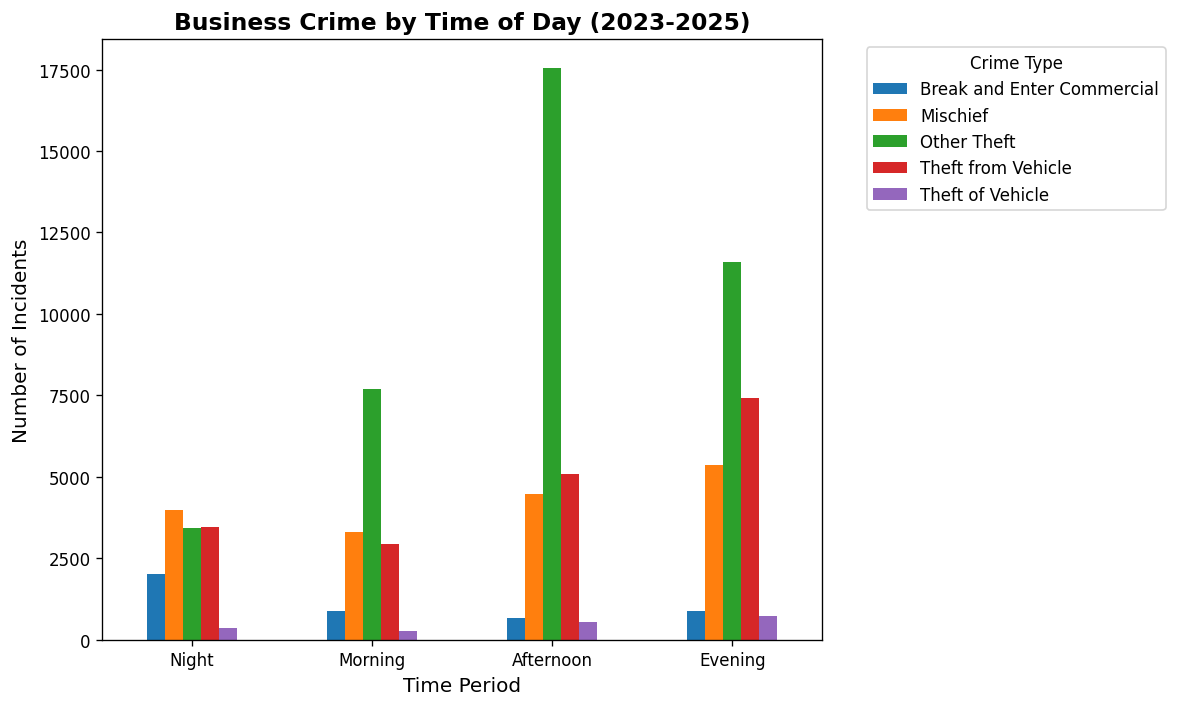

In [ ]:
# Bucket hours into time-of-day periods inline
import pandas as pd

time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
time_bins = [-1, 5, 11, 17, 23] # -1 to include hour 0 (midnight)

period = pd.cut(biz_full['HOUR'], bins=time_bins, labels=time_labels)

# Count crimes by period and type
tod_counts = biz_full.groupby([period, 'TYPE']).size().unstack(fill_value=0)

# Reorder to logical time sequence
tod_counts = tod_counts.reindex(time_labels)

tod_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Business Crime by Time of Day (2023-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Time Period')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../img/biz_crime_time_of_day.png', bbox_inches='tight')
plt.show()

### 5.5 Monthly Crime Trends -- Are There Seasonal Patterns?

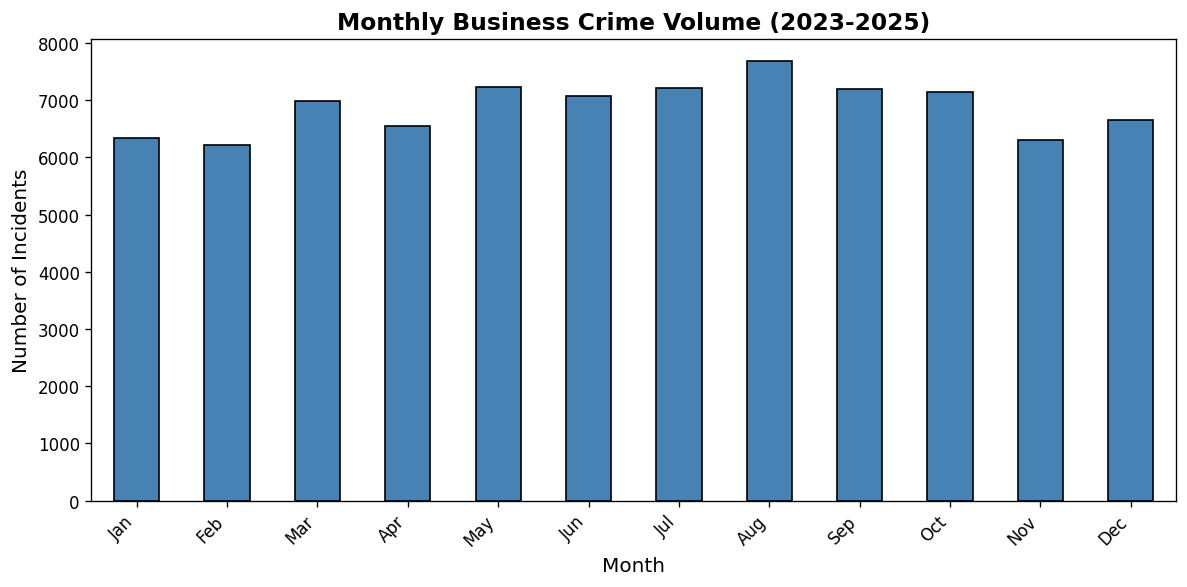

In [15]:
# Monthly trend aggregated over 2023-2025
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

monthly = biz_full.groupby('MONTH').size()
monthly.index = monthly.index.map(month_names)

fig, ax = plt.subplots(figsize=(10, 5))
monthly.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')

ax.set_title('Monthly Business Crime Volume (2023-2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Incidents')
ax.set_xticklabels(monthly.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../img/biz_crime_monthly.png', bbox_inches='tight')
plt.show()

## 6. Key Findings

1. **Downtown dominates:** The Central Business District consistently records the highest volume of business-relevant crime, far exceeding other neighbourhoods.
2. **Theft from vehicles is #1:** Across all neighbourhoods, theft from vehicles is the most common crime type affecting businesses.
3. **Year-over-year trends vary by type:** Some crime categories show a declining trend while others remain stable or increase slightly.
4. **Crime composition differs by area:** The heatmap reveals that the *mix* of crime types varies across neighbourhoods, not just the volume.
5. **Afternoon and evening are peak periods:** Time-of-day bucketing shows business crimes concentrate in the Afternoon (12-17h) and Evening (18-23h) windows, which aligns with business operating hours and after-hours vulnerability.
6. **Summer months see more crime:** Monthly aggregation reveals a seasonal uptick during warmer months (roughly May-October), likely linked to increased foot traffic and longer daylight hours, but is *insignificant and inconclusive*.